# Building Pipeline For The Titanic Dataset

## Introduction
[Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) helps with building entire workflows

These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.


**Components** performs a single step in a Machine Learning workflow such (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning).

**Dataset:** Titanic dataset, contains data collated from the ship’s manifest on its passengers. There are 1309 rows of data segmented in train and test files.

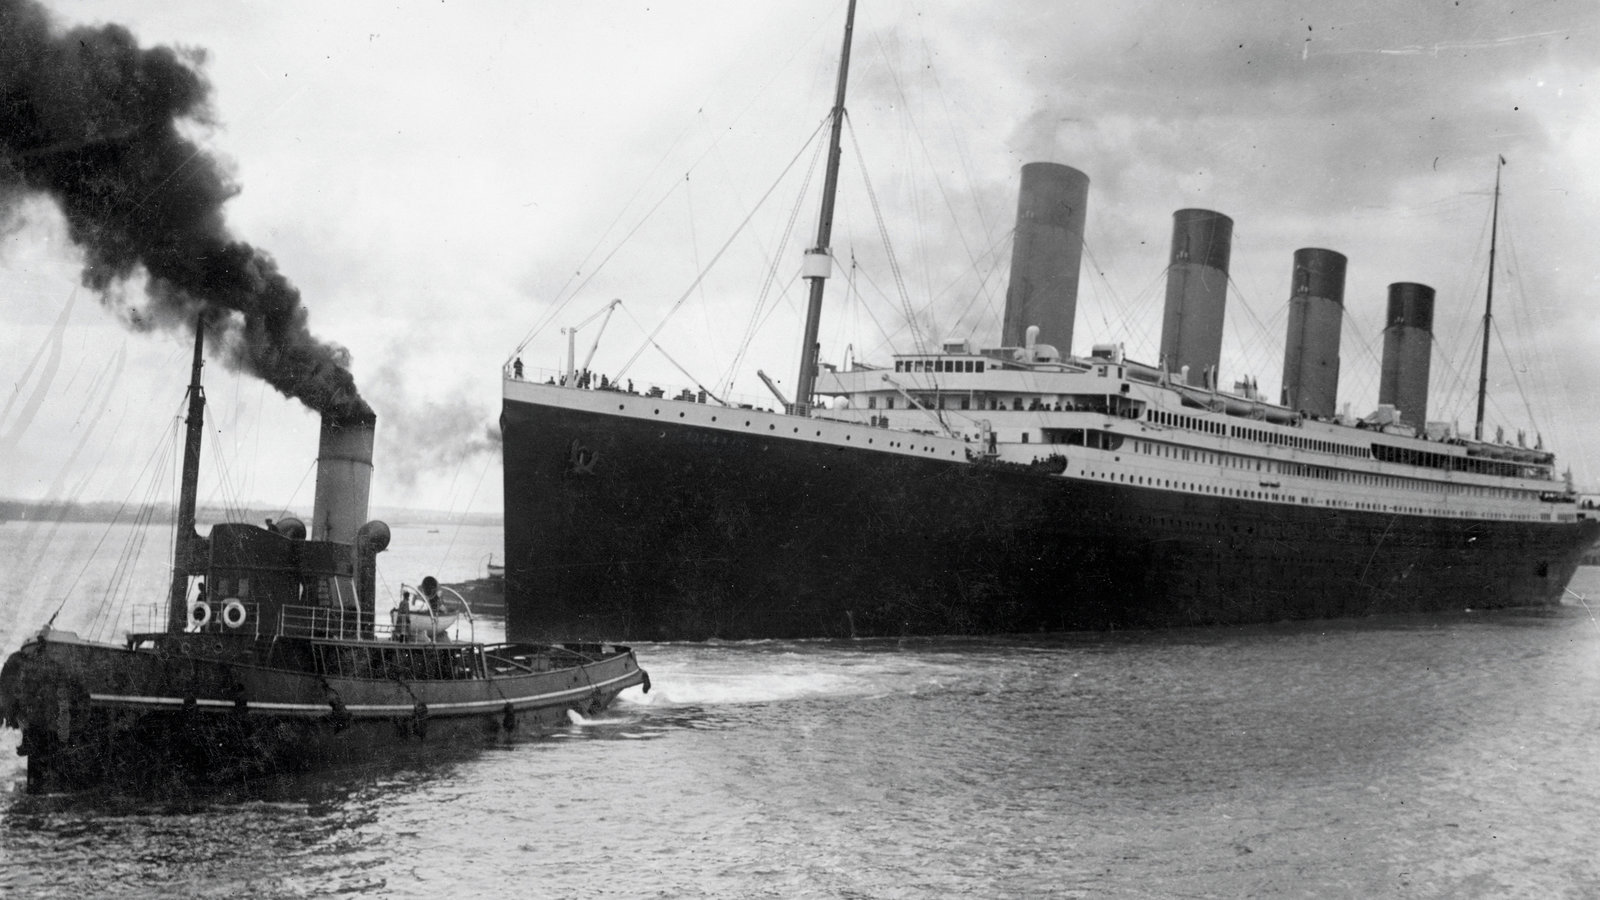


## Prerequisites
check to see if kfp is installed:

In [ ]:
! pip3 show kfp

## Configure access Minio

### Upload our Training Dataset to Minio

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

Follow the steps below to download minio client
<div class="alert">
   <code>
    wget https://dl.min.io/client/mc/release/linux-amd64/mc
    chmod +x mc
    ./mc --help
    </code>

</div>




In [ ]:
! wget https://dl.min.io/client/mc/release/linux-amd64/mc
! chmod +x mc
! ./mc --help

#### a. Connect to the Minio Server

In [ ]:
! ./mc alias set minio http://minio-service.kubeflow:9000 minio minio123

#### b. Create a bucket to store your data and export your model to Minio

**Make sure you clear this bucket once you are cone running your pipeline**

In [ ]:
! ./mc mb minio/titanic

In [ ]:
! ./mc ls minio mlpipeline

#### c. Upload the dataset to your bucket in Minio.

**Note**: Make sure you have your dataset in a folder like we have here as <code>datasets</code>.

In [ ]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/titanic/datasets.tar.gz
! ./mc policy set download minio/titanic

### If you have downloaded your data too many times while testing, use the following code to clear out your bucket

In [ ]:
# ! ./mc rm --recursive --force minio/titanic

### Minio Server URL and Credentials

In [ ]:
MINIO_SERVER='minio-service.kubeflow:9000'
MINIO_ACCESS_KEY='minio'
MINIO_SECRET_KEY='minio123'

## How to Implement Kubeflow Pipelines Components

In this pipeline, we have the following components:
- Titanic dataset download component
- Preprocess the dataset component
- Feature Engineering for the Titanic DataSet
- Train the models component
- Export the trained model component

In [ ]:
from typing import NamedTuple
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath #helps define the input & output between the components

### Component 1: Download the Data Set

In [ ]:
def download_dataset(minio_server: str,data_dir: OutputPath(str)):

    import urllib.request
    import tarfile
    import os
    import subprocess

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = f'http://{minio_server}/titanic/datasets.tar.gz'
    stream = urllib.request.urlopen(url)
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)
    

    subprocess.call(["ls", "-dlha", data_dir])

### Component 2: Preprocess the Titanic DataSet

In [ ]:
def preprocess_dataset(data_dir: InputPath(str), preprocessed_data_dir: OutputPath(str)):
    
    import pandas as pd
    import pickle
    import re
    import numpy as np
    import os
    import subprocess
    
    
    train_df = pd.read_csv(f"{data_dir}/datasets/train.csv")
    test_df= pd.read_csv(f"{data_dir}/datasets/test.csv")
    
    data = [train_df, test_df]
    for dataset in data:
        dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
        dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
        dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
        dataset['not_alone'] = dataset['not_alone'].astype(int)
        
    # This does not contribute to a person survival probability
    train_df = train_df.drop(['PassengerId'], axis=1)
   
    #dealing with missing data in cabin feature
    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    data = [train_df, test_df]

    for dataset in data:
        dataset['Cabin'] = dataset['Cabin'].fillna("U0")
        dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
        dataset['Deck'] = dataset['Deck'].map(deck)
        dataset['Deck'] = dataset['Deck'].fillna(0)
        dataset['Deck'] = dataset['Deck'].astype(int)
    # we can now drop the cabin feature
    train_df = train_df.drop(['Cabin'], axis=1)
    test_df = test_df.drop(['Cabin'], axis=1)
    
    #dealing with missing data in age feature
    data = [train_df, test_df]
    
    for dataset in data:
        mean = train_df["Age"].mean()
        std = test_df["Age"].std()
        is_null = dataset["Age"].isnull().sum()
        # compute random numbers between the mean, std and is_null
        rand_age = np.random.randint(mean - std, mean + std, size = is_null)
        # fill NaN values in Age column with random values generated
        age_slice = dataset["Age"].copy()
        age_slice[np.isnan(age_slice)] = rand_age
        dataset["Age"] = age_slice
        dataset["Age"] = train_df["Age"].astype(int)

    #dealing with missing data in emabrk feature
    # fill with most common value
    common_value = 'S'
    data = [train_df, test_df]

    for dataset in data:
        dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
    
    os.makedirs(preprocessed_data_dir, exist_ok=True)
                         
    train_df.to_pickle(f'{preprocessed_data_dir}/train.pkl')
    test_df.to_pickle(f'{preprocessed_data_dir}/test.pkl')
    
    return(print('Done!'))

### Component 3: Feature Engineering for the Titanic DataSet

In [ ]:
def feateng_dataset(preprocessed_data_dir: InputPath(str), feature_dir: OutputPath(str)):
        
    import pandas as pd
    import pickle
    import re
    import numpy as np
    import os
    
    #loading the preprocessed data
    train_df = pd.read_pickle(f'{preprocessed_data_dir}/train.pkl')
    test_df = pd.read_pickle(f'{preprocessed_data_dir}/test.pkl')
    
    
    data = [train_df, test_df]
    for dataset in data:
        dataset['Fare'] = dataset['Fare'].fillna(0)
        dataset['Fare'] = dataset['Fare'].astype(int)
        
    #title features
    data = [train_df, test_df]
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

    for dataset in data:
        # extract titles
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        # replace titles with a more common title or as Rare
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                                'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
        # convert titles into numbers
        dataset['Title'] = dataset['Title'].map(titles)
        # filling NaN with 0, to get safe
        dataset['Title'] = dataset['Title'].fillna(0)
    train_df = train_df.drop(['Name'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    
    #mapping sex feature into numeric
    genders = {"male": 0, "female": 1}
    data = [train_df, test_df]

    for dataset in data:
        dataset['Sex'] = dataset['Sex'].map(genders)
    
    #dropping ticket feature
    train_df = train_df.drop(['Ticket'], axis=1)
    test_df = test_df.drop(['Ticket'], axis=1)
    
    #mapping embarked into numeric
    ports = {"S": 0, "C": 1, "Q": 2}
    data = [train_df, test_df]

    for dataset in data:
        dataset['Embarked'] = dataset['Embarked'].map(ports)
      
    #grouping age into categories
    data = [train_df, test_df]
    for dataset in data:
        dataset['Age'] = dataset['Age'].astype(int)
        dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
        dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
        dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
        dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
        dataset.loc[ dataset['Age'] > 66, 'Age'] = 6
     
    #grouping fare into categories
    data = [train_df, test_df]

    for dataset in data:
        dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
        dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
        dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
        dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
        dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
        dataset['Fare'] = dataset['Fare'].astype(int)
        
    #adding new feature
    #age times class
    data = [train_df, test_df]
    for dataset in data:
        dataset['Age_Class']= dataset['Age']* dataset['Pclass']
    #fare per head    
    for dataset in data:
        
        dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
        dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    
    X_train = train_df.drop("Survived",axis=1)
    Y_train = train_df["Survived"]
    X_test  = test_df.drop("PassengerId",axis=1)
    X_test  = X_test.copy()
    
    #Save the train_data as a pickle file to be used by the train component.
    os.makedirs(feature_dir, exist_ok=True)
    
    with open(f'{feature_dir}/train', 'wb') as f:
        pickle.dump((X_train,  Y_train), f)
    
    #Save the test_feature as a pickle file to be used.
    with open(f'{feature_dir}/test', 'wb') as f:
        pickle.dump(X_test, f)
        
    return(print('Done!'))

### Component 4: Train the Model

#### a. Logistic Regression

In [ ]:
def logistic_reg(feature_dir: InputPath(str), l_models_dir: OutputPath(str)):
    
    import pickle
    import os
    import numpy as np
    import pandas as pd
    from sklearn import linear_model
    from sklearn.linear_model import LogisticRegression

    #loading the train data
    with open(f'{feature_dir}/train', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, Y_train = train_data
    
    logreg = LogisticRegression(solver='lbfgs', max_iter=110)
    logreg.fit(X_train, Y_train)
    acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
    
    os.makedirs(l_models_dir, exist_ok=True)
    #Save the accuracy as a pickle file to be used 
    with open(f'{l_models_dir}/logistic_reg', 'wb') as f:
        pickle.dump(acc_log, f)
    
    return(print('Done!'))
    

#### b. Gaussian Naive Bayes

In [ ]:
def gaussian_NB(feature_dir: InputPath(str), g_models_dir: OutputPath(str)):
    
    import pickle
    from sklearn import linear_model
    from sklearn.naive_bayes import GaussianNB
    import os
    import pandas as pd
    import numpy as np
    
    #loading the train data
    with open(f'{feature_dir}/train', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, Y_train = train_data
    
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
    
    os.makedirs(g_models_dir, exist_ok=True)
    #Save the accuracy as a pickle file to be used 
    with open(f'{g_models_dir}/gaus_NB', 'wb') as f:
        pickle.dump(acc_gaussian, f)
    
    return(print('Done!'))

#### c. SVM

In [ ]:
def SVM(feature_dir: InputPath(str), s_models_dir: OutputPath(str)):
    import pickle
    from sklearn import linear_model
    from sklearn.svm import SVC
    import os
    import pandas as pd
    import numpy as np
    
    #loading the train data
    with open(f'{feature_dir}/train', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, Y_train = train_data
    
    linear_svc = SVC(gamma='auto')
    linear_svc.fit(X_train, Y_train)
    acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
    
    os.makedirs(s_models_dir, exist_ok=True)
    #Save the accuracy as a pickle file to be used 
    with open(f'{s_models_dir}/svm', 'wb') as f:
        pickle.dump(acc_linear_svc, f)
    
    return(print('Done!'))

#### d. Decision Tree

In [ ]:
def decision_tree(feature_dir: InputPath(str), d_models_dir: OutputPath(str)):
    
    import pickle
    from sklearn import linear_model
    from sklearn.tree import DecisionTreeClassifier
    import os
    import pandas as pd
    import numpy as np
    
    #loading the train data
    with open(f'{feature_dir}/train', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, Y_train = train_data
    
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
    
    os.makedirs(d_models_dir, exist_ok=True)
    #Save the accuracy as a pickle file to be used 
    with open(f'{d_models_dir}/decision_tree', 'wb') as f:
        pickle.dump(acc_decision_tree, f)
    
    return(print('Done!'))

### Component 4: Export the Model

In [ ]:
def export_model(
    l_models_dir: InputPath(str),
    g_models_dir: InputPath(str),
    s_models_dir: InputPath(str),
    d_models_dir: InputPath(str),
    export_bucket: str,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url=f'http://{minio_server}',
        aws_access_key_id=minio_access_key,
        aws_secret_access_key=minio_secret_key,
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    models_name = []
    for i in os.listdir(l_models_dir):
        models_name.append(i)
    for root, dirs, files in os.walk(l_models_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, l_models_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## Combine the Components into a Pipeline


In [ ]:
def train_model_pipeline(
    data_dir: str,
    preprocessed_data_dir: str,
    feature_dir: str,
    l_models_dir: str,
    g_models_dir: str,
    s_models_dir: str,
    d_models_dir: str,
    export_bucket: str,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mavencodev/minio:v.0.1"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )(minio_server)

    preprocessOp = components.func_to_container_op(preprocess_dataset,base_image=BASE_IMAGE)(
        downloadOp.output
    )
    
    featureOp = components.func_to_container_op(feateng_dataset, base_image=BASE_IMAGE)(
        preprocessOp.output
    )
    
    
    logistic_regOp = components.func_to_container_op(logistic_reg, base_image=BASE_IMAGE)(
        featureOp.output
    )
    
    gaussian_NB_Op = components.func_to_container_op(gaussian_NB, base_image=BASE_IMAGE)(
        featureOp.output
    )
    
    svmOp = components.func_to_container_op(SVM, base_image=BASE_IMAGE)(
        featureOp.output
    )
    
    decision_treesOp = components.func_to_container_op(decision_tree, base_image=BASE_IMAGE)(
        featureOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        logistic_regOp.output, gaussian_NB_Op.output, svmOp.output, decision_treesOp.output,
        export_bucket, minio_server, minio_access_key, minio_secret_key
    )


In [ ]:
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="Titanic Pipeline",
    description="A sample pipeline to demonstrate different model training, evaluation and export",
)
def titanic_pipeline(
    l_models_dir: str= "/train/models",
    g_models_dir: str= "/train/models",
    s_models_dir: str= "/train/models",
    d_models_dir: str= "/train/models",
    data_dir: str = "/train/data",
    preprocessed_data_dir: str = "/train/preprocessed",
    feature_dir: str = "/train/features",
    export_bucket: str = "titanic"
   
):
    MINIO_SERVER='minio-service.kubeflow:9000'
    MINIO_ACCESS_KEY='minio'
    MINIO_SECRET_KEY='minio123'
    
    train_model_pipeline(
        data_dir=data_dir,
        preprocessed_data_dir=preprocessed_data_dir,
        feature_dir=feature_dir,
        l_models_dir=l_models_dir,
        g_models_dir=g_models_dir,
        s_models_dir= s_models_dir,
        d_models_dir=d_models_dir,
        export_bucket=export_bucket,
        minio_server=MINIO_SERVER,
        minio_access_key=MINIO_ACCESS_KEY,
        minio_secret_key=MINIO_SECRET_KEY,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [ ]:
pipeline_func = titanic_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End-Demo"


kfp.compiler.Compiler().compile(pipeline_func,  'titanic_pipeline.yaml')
    

#### Upload the generated yaml file to create a pipeline in Kubeflow UI

##### Now delete your bucket when you have run the pipeline successfully in the Kubeflow UI.

In [ ]:
# ! ./mc rb minio/titanic --force